In [39]:
import yfinance as yf
import pandas as pd
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt

def fetch_data(ticker, start_date='2021-01-01', end_date='2024-01-01'):
    """Fetch historical data for the given ticker."""
    return yf.download(ticker, start=start_date, end=end_date)

def ewmac(price, vol, Lfast, Lslow):
    """
    Calculate the ewmac trading rule forecast, given a price, volatility and EWMA speeds Lfast and Lslow

    Assumes that 'price' and vol is daily data

    This version uses a precalculated price volatility, and does not do capping or scaling

    :param price: The price or other series to use (assumed Tx1)
    :type price: pd.Series

    :param vol: The daily price unit volatility (NOT % vol)
    :type vol: pd.Series aligned to price

    :param Lfast: Lookback for fast in days
    :type Lfast: int

    :param Lslow: Lookback for slow in days
    :type Lslow: int

    :returns: pd.Series -- unscaled, uncapped forecast
    """
    fast_ewma = price.ewm(span=Lfast, min_periods=1).mean()
    slow_ewma = price.ewm(span=Lslow, min_periods=1).mean()
    raw_ewmac = fast_ewma - slow_ewma
    return raw_ewmac / vol.ffill()


def calculate_ewmac_signals(data, parameters):
    """
    Calculate EWMAC signals for a given price series, volatility, and a list of parameters.

    :param price: The price series
    :type price: pd.Series

    :param volatility: The volatility series
    :type volatility: pd.Series

    :param parameters: List of tuples containing fast and slow parameters
    :type parameters: list of tuples

    :returns: pd.DataFrame -- DataFrame containing EWMAC signals for each parameter pair
    """
    for filter_speed in parameters:
        data[f'EWMAC_{filter_speed}'] = scale_cap_forecast(ewmac(data['Close'], data['Volatility'], filter_speed, 4*filter_speed))
    return data


def scale_cap_forecast(signals, cap=20):
    """
    Scale the forecast so it has an expected absolute average value of 10.

    :param signals: EWMAC signals.
    :return: Scaled signals.
    """
    signals = signals * 10 / signals.abs().mean()
    return signals.clip(-cap, cap)

def calculate_pnl(position_size, prices, multiplier=1000):
    return (position_size * prices * 1000).replace(0.0, np.nan).interpolate()
    
def plot_position_size(position_size, price):
    """
    Plot position size against underlying price with vertical lines indicating periods of long and short positions.

    :param position_size: Position size data.
    :param price: Underlying price data.
    """
    fig = go.Figure()

    # Plot underlying price
    fig.add_trace(go.Scatter(x=price.index, y=price, mode='lines', name='Price', line=dict(color='blue')))

    # Create a separate y-axis for position size
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size, mode='lines', name='Position Size', line=dict(color='red'), yaxis='y2'))

    # Add fill areas for long and short positions
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))

    # Add vertical lines for direction change
    for i in range(1, len(position_size)):
        if position_size.iloc[i] != 0 and position_size.iloc[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=position_size.index[i], x1=position_size.index[i], y0=0, y1=1, line=dict(color="green" if position_size[i] > 0 else "red", width=1), opacity=0.1)

    # Set layout
    fig.update_layout(title='Position Size vs Underlying Price with Direction Change Indicators', xaxis_title='Date')

    # Ensure both y-axes share y=0
    fig.update_layout(yaxis=dict(title='Price', color='blue'),
                      yaxis2=dict(title='Position Size', color='red', overlaying='y', side='right'))
    
    fig.show()

def plot_position_size_vs_pnl(position_size, price):
    """
    Plot position size against PNL with vertical lines indicating periods of long and short positions.

    :param position_size: Position size data.
    :param pnl: Profit and Loss data.
    """
    pnl = (calculate_pnl(position_size, price))
    fig = go.Figure()

    # Plot PNL
    fig.add_trace(go.Scatter(x=pnl.index, y=pnl, mode='lines', name='PNL', line=dict(color='blue')))

    # Create a separate y-axis for position size
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size, mode='lines', name='Position Size', line=dict(color='red'), yaxis='y2'))

    # Add fill areas for long and short positions
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))

    # Add vertical lines for direction change
    for i in range(1, len(position_size)):
        if position_size.iloc[i] != 0 and position_size.iloc[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=position_size.index[i], x1=position_size.index[i], y0=0, y1=1, line=dict(color="green" if position_size[i] > 0 else "red", width=1), opacity=0.1)

    # Set layout
    fig.update_layout(title='Position Size vs PNL with Direction Change Indicators', xaxis_title='Date')

    # Ensure both y-axes share y=0
    fig.update_layout(yaxis=dict(title='PNL', color='blue'),
                      yaxis2=dict(title='Position Size', color='red', overlaying='y', side='right'))
    
    fig.show()


In [43]:
def calculate_position_size(capped_signals, risk_target, volatility, price, capital, instrument_weights, fx_rate, idm):
    """
    Calculate the position size based on capped signals, risk target, and other parameters.

    :param capped_signals: DataFrame containing capped EWMAC signals.
    :param risk_target: Annualized risk target.
    :param volatility: Current volatility of the instrument.
    :param price: Current price of the instrument.
    :param capital: Total capital available for trading.
    :param instrument_weights: Weights of instruments in the portfolio.
    :param fx_rate: Exchange rate if applicable.
    :param IDM: Instrument Diversification Multiplier.
    :return: Position size.
    """
    multiplier = 1000
    # Calculate the average of capped signals
    average_signal = capped_signals.mean(axis=1)
    
    # Calculate risk-adjusted unrounded position
    position = average_signal * capital * idm * instrument_weights * risk_target / (10 * multiplier * price * fx_rate * volatility)
    
    return position

def calculate_backtest_metrics(data, capital, strat):
    """
    Calculate various backtest metrics based on position size and price data.

    :param position_size: Series containing position size data.
    :param price_data: Series containing price data.

    :return: Dictionary containing backtest metrics.
    """
    # Calculate P&L (Profit and Loss)
    pnl = calculate_pnl(data['Position Size'], data['Daily_Returns'])
    
    # Calculate cumulative P&L
    cumulative_pnl = pnl.cumsum()

    # Calculate Sharpe ratio ################
    sharpe_ratio = pnl.mean() / pnl.std() * (252 ** 0.5)

    # Calculate annualized return
    annualized_return = pnl.mean() * 252

    annualized_return_pct = annualized_return*100/capital

    # Additional metrics
    drawdowns = cumulative_pnl - cumulative_pnl.cummax()
    avg_drawdown = drawdowns.mean()

    # Calculate average position size
    avg_position = data['Position Size'].abs().mean()
    turnover = (data['Position Size'].diff().abs() / avg_position).sum()
    skew = pnl.skew()
    lower_tail = pnl.quantile(0.05)
    upper_tail = pnl.quantile(0.95)
    alpha = (cumulative_pnl.iloc[-1] / cumulative_pnl.std()) * (252 ** 0.5)
    
    return pd.DataFrame({
        "Initial Capital": capital,
        "Mean Annualised Return  %": annualized_return_pct,
        "Avg Drawdown %": avg_drawdown,
        "Annual Standard Deviation %": pnl.std() * (252 ** 0.5),
        "Sharpe Ratio": sharpe_ratio,
        "Turnover": turnover,
        "Skew": skew,
        "Lower Tail (5th percentile)": lower_tail,
        "Upper Tail (95th percentile)": upper_tail,
        # "Alpha": alpha,
        "Cumulative PnL": cumulative_pnl.iloc[-1]
    }, index=[strat]).T

def backtest(ticker = 'BZ=F', start_date = '2020-01-01', end_date = '2024-01-01', parameters = [4, 8, 16, 32, 64],
             risk_target = 0.1, capital = 100000, plot=True):
    strat = "EWMAC_"  + '_'.join([str(i) for i in parameters])
    instrument_weights = 1 # Example instrument weights
    fx_rate = 1.0  # Example exchange rate if applicable
    idm = 1  # Example Instrument Diversification Multiplier

    # Fetch data
    data = fetch_data(ticker, start_date, end_date)

    # Calculate daily returns
    data['Daily_Returns'] = data['Close'].pct_change()

    # Calculate volatility
    data['Volatility'] = data['Daily_Returns'].ewm(span=30, min_periods=0).std()

    # Calculate EWMAC signals (scaled and capped)
    data = calculate_ewmac_signals(data, parameters)
    signal_cols = [i for i in data.columns if "EWM" in i]

    # Calculate position size
    data["Position Size"] = calculate_position_size(data[signal_cols], risk_target, data['Volatility'], data['Close'], capital, instrument_weights, fx_rate, idm)

    backtest_metrics = calculate_backtest_metrics(data, capital, strat)
    
    pd.options.display.float_format = '{:.2f}'.format  # Adjust precision as needed
    # Print the calculated metrics
    print(backtest_metrics.round(2))

    if plot==True:
        plot_position_size(data["Position Size"], data['Close'])
        plot_position_size_vs_pnl(data["Position Size"], data['Close'])

    return data


In [46]:
data = backtest(plot=True)
# data

[*********************100%***********************]  1 of 1 completed
                              EWMAC_4_8_16_32_64
Initial Capital                        100000.00
Mean Annualised Return  %                   4.70
Avg Drawdown %                           -434.22
Annual Standard Deviation %              2123.83
Sharpe Ratio                                2.21
Turnover                                  110.44
Skew                                        0.77
Lower Tail (5th percentile)              -175.98
Upper Tail (95th percentile)              240.89
Cumulative PnL                          18688.74


In [13]:
ps, px = data['Position Size'], data['Close']

(array([ 32., 140., 249., 215., 125.,  85.,  55.,  42.,  41.,  18.]),
 array([-773365.80224546, -516284.33794806, -259202.87365065,
          -2121.40935325,  254960.05494416,  512041.51924157,
         769122.98353897, 1026204.44783638, 1283285.91213379,
        1540367.37643119, 1797448.8407286 ]),
 <BarContainer object of 10 artists>)

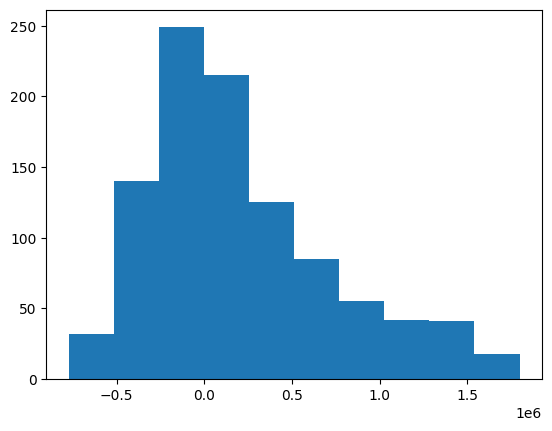

In [26]:
a = calculate_pnl(ps,px)
plt.hist(a)

In [251]:
np.log(pnl).pct_change().std()

c:\Users\karan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

invalid value encountered in log

C:\Users\karan\AppData\Local\Temp\ipykernel_14964\1982602473.py:1: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



2.280795863134806

In [257]:
std = np.log(pnl / pnl.shift(1)).replace(0, np.nan).interpolate().mean() * 252

std

c:\Users\karan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

invalid value encountered in log



6.019583135972088

In [78]:
import yfinance as yf
import pandas as pd
import plotly.graph_objs as go
import numpy as np

def fetch_data(ticker, start_date='2020-01-01', end_date='2024-01-01'):
    """Fetch historical data for the given ticker."""
    return yf.download(ticker, start=start_date, end=end_date)

def ewmac(price, vol, Lfast, Lslow):
    fast_ewma = price.ewm(span=Lfast, min_periods=1).mean()
    slow_ewma = price.ewm(span=Lslow, min_periods=1).mean()
    raw_ewmac = fast_ewma - slow_ewma
    return raw_ewmac / vol.ffill()

def calculate_ewmac_signals(data, parameters):
    for filter_speed in parameters:
        Lfast = filter_speed
        Lslow = 4 * filter_speed
        signal_name = f'EWMAC_{filter_speed}'
        data[signal_name] = scale_cap_forecast(ewmac(data['Close'], data['Volatility'], Lfast, Lslow))
    return data

def scale_cap_forecast(signals, cap=20):
    signals = signals * 10 / signals.abs().mean()
    return signals.clip(-cap, cap)

def calculate_pnl(trades, data, transaction_cost=0.001, multiplier=1):
    trades['Price Change'] = data['Close'].diff().fillna(0)
    trades['Position Change'] = trades['Position'].diff().fillna(0)
    trades['Trade Price'] = trades['Position Change'] * data['Close'] * multiplier
    trades['Realized PnL'] = trades['Trade Price'] - transaction_cost * trades['Trade Price'].abs()
    trades['Cumulative Realized PnL'] = trades['Realized PnL'].cumsum()
    trades['Unrealized PnL'] = trades['Position'] * trades['Price Change'] * multiplier
    trades['Total PnL'] = trades['Cumulative Realized PnL'] + trades['Unrealized PnL']
    return trades

def plot_position_size(position_size, price):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=price.index, y=price, mode='lines', name='Price', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size, mode='lines', name='Position Size', line=dict(color='red'), yaxis='y2'))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))

    for i in range(1, len(position_size)):
        if position_size.iloc[i] != 0 and position_size.iloc[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=position_size.index[i], x1=position_size.index[i], y0=0, y1=1, line=dict(color="green" if position_size[i] > 0 else "red", width=1), opacity=0.1)

    fig.update_layout(title='Position Size vs Underlying Price with Direction Change Indicators', xaxis_title='Date')
    fig.update_layout(yaxis=dict(title='Price', color='blue'),
                      yaxis2=dict(title='Position Size', color='red', overlaying='y', side='right'))
    
    fig.show()

def plot_position_size_vs_pnl(trades, pnl):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=pnl.index, y=pnl, mode='lines', name='PNL', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'], mode='lines', name='Position Size', line=dict(color='red'), yaxis='y2'))
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'] * (trades['Position'] > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'] * (trades['Position'] < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))

    for i in range(1, len(trades)):
        if trades['Position'].iloc[i] != 0 and trades['Position'].iloc[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=trades.index[i], x1=trades.index[i], y0=0, y1=1, line=dict(color="green" if trades['Position'].iloc[i] > 0 else "red", width=1), opacity=0.1)

    fig.update_layout(title='Position Size vs PNL with Direction Change Indicators', xaxis_title='Date')
    fig.update_layout(yaxis=dict(title='PNL', color='blue'),
                      yaxis2=dict(title='Position Size', color='red', overlaying='y', side='right'))
    
    fig.show()

def adjust_trade_buffer(data, max_loss_sharpe, window=30):
    """
    Adjust trade buffer to ensure the maximum loss Sharpe ratio does not exceed the given threshold.
    
    :param data: DataFrame containing the daily returns and position sizes.
    :param max_loss_sharpe: Maximum loss Sharpe ratio threshold.
    :param window: Rolling window size in days.
    :return: Adjusted trade buffer.
    """
    # Calculate rolling mean and standard deviation of daily returns
    rolling_mean = data['Daily_Returns'].rolling(window=window).mean()
    rolling_std = data['Daily_Returns'].rolling(window=window).std()

    # Calculate rolling Sharpe ratio (assumes risk-free rate is 0)
    rolling_sharpe = rolling_mean / rolling_std

    # Calculate the trade buffer based on the max loss Sharpe ratio
    trade_buffer = (rolling_sharpe.abs() / max_loss_sharpe).clip(lower=1)
    
    return trade_buffer

def calculate_backtest_metrics(trades, capital, strat, multiplier=1):
    """
    Calculate various backtest metrics based on position size and price data.

    :param trades: DataFrame containing trades data.
    :param capital: Initial capital for the backtest.
    :param strat: Strategy name.
    :param multiplier: Multiplier for futures contracts.

    :return: DataFrame containing backtest metrics.
    """
    # Calculate daily returns
    daily_pnl = trades['Total PnL'].diff().fillna(0)
    
    # Calculate cumulative P&L
    cumulative_pnl = trades['Total PnL']

    # Calculate daily mean return and standard deviation from PnL
    daily_mean_return = daily_pnl.mean()
    daily_std_dev = daily_pnl.std()

    # Annualize the mean return and standard deviation
    annualized_return = daily_mean_return * 252 / capital
    annualized_std_dev = daily_std_dev * np.sqrt(252) / capital

    # Calculate the annualized Sharpe ratio
    sharpe_ratio = annualized_return / annualized_std_dev

    # Calculate annualized return percentage
    annualized_return_pct = annualized_return * 100

    # Additional metrics
    drawdowns = cumulative_pnl - cumulative_pnl.cummax()
    max_drawdown = drawdowns.min()
    avg_drawdown = drawdowns.mean()

    # Calculate average position size
    avg_position = trades['Position'].abs().mean()

    # Calculate annual turnover
    total_turnover = trades['Position'].diff().abs().sum()
    annual_turnover = total_turnover / avg_position / len(trades) * 252

    skew = daily_pnl.skew()
    lower_tail = daily_pnl.quantile(0.05)
    upper_tail = daily_pnl.quantile(0.95)
    alpha = (cumulative_pnl.iloc[-1] / cumulative_pnl.std()) * np.sqrt(252)

    return pd.DataFrame({
        "Initial Capital": capital,
        "Mean Annualised Return  %": annualized_return_pct,
        "Max Drawdown %": max_drawdown / capital * 100,
        "Avg Drawdown %": avg_drawdown / capital * 100,
        "Annual Standard Deviation %": annualized_std_dev * 100,
        "Sharpe Ratio": sharpe_ratio,
        "Annual Turnover": annual_turnover,
        "Skew": skew,
        "Lower Tail (5th percentile)": lower_tail,
        "Upper Tail (95th percentile)": upper_tail,
        "Cumulative PnL": cumulative_pnl.iloc[-1]
    }, index=[strat]).T

def calculate_position_size(capped_signals, risk_target, volatility, price, capital, instrument_weights, fx_rate, idm):
    """
    Calculate the position size based on capped signals, risk target, and other parameters.

    :param capped_signals: DataFrame containing capped EWMAC signals.
    :param risk_target: Annualized risk target.
    :param volatility: Current volatility of the instrument.
    :param price: Current price of the instrument.
    :param capital: Total capital available for trading.
    :param instrument_weights: Weights of instruments in the portfolio.
    :param fx_rate: Exchange rate if applicable.
    :param idm: Instrument Diversification Multiplier.
    :return: Position size.
    """
    multiplier = 1000
    # Calculate the weighted average of capped signals
    weighted_signals = capped_signals.mul(instrument_weights, axis=1)
    average_signal = weighted_signals.sum(axis=1)

    # Calculate risk-adjusted unrounded position
    position = average_signal * capital * idm * risk_target / (10 * multiplier * price * fx_rate * volatility)
    
    return position

def backtest(ticker='BZ=F', start_date='2020-01-01', end_date='2024-01-01', parameters=[4, 8, 16, 32, 64],
             risk_target=0.2, capital=100000, plot=True, transaction_cost=0.0002, max_loss_sharpe=0.1):
    strat = "EWMAC_" + '_'.join([str(i) for i in parameters])
    instrument_weights = 1  # Example instrument weights
    fx_rate = 1.0  # Example exchange rate if applicable
    idm = 1  # Example Instrument Diversification Multiplier

    # Fetch data
    data = fetch_data(ticker, start_date, end_date)

    # Calculate daily returns
    data['Daily_Returns'] = data['Close'].pct_change()

    # Calculate volatility
    data['Volatility'] = data['Daily_Returns'].ewm(span=30, min_periods=0).std()

    # Calculate EWMAC signals (scaled and capped)
    data = calculate_ewmac_signals(data, parameters)
    signal_cols = [i for i in data.columns if "EWM" in i]

    # Calculate ideal position size
    data["Ideal Position Size"] = calculate_position_size(data[signal_cols], risk_target, data['Volatility'], data['Close'], capital, instrument_weights, fx_rate, idm)

    # Adjust trade buffer based on max loss Sharpe ratio
    data['Trade Buffer'] = adjust_trade_buffer(data, max_loss_sharpe)

    # Apply trade buffer
    data['Position Size'] = data['Ideal Position Size'].where(
        (data['Ideal Position Size'] - data['Ideal Position Size'].shift(1)).abs() > data['Trade Buffer'],
        other=np.nan
    ).ffill().fillna(0)

    # Create trades DataFrame
    trades = pd.DataFrame(index=data.index)
    trades['Position'] = data["Position Size"]
    trades = calculate_pnl(trades, data, transaction_cost, multiplier=1)

    # Calculate backtest metrics
    backtest_metrics = calculate_backtest_metrics(trades, capital, strat)
    
    pd.options.display.float_format = '{:.2f}'.format  # Adjust precision as needed
    # Print the calculated metrics
    print(backtest_metrics.round(2))

    if plot:
        plot_position_size(data["Position Size"], data['Close'])
        plot_position_size_vs_pnl(trades, trades['Total PnL'].cumsum())

    return data

# Run the backtest
data = backtest()
data


[*********************100%***********************]  1 of 1 completed
                              EWMAC_4_8_16_32_64
Initial Capital                        100000.00
Mean Annualised Return  %                  -0.76
Max Drawdown %                            -12.56
Avg Drawdown %                             -5.40
Annual Standard Deviation %                 5.74
Sharpe Ratio                               -0.13
Annual Turnover                            25.04
Skew                                       -3.04
Lower Tail (5th percentile)              -455.21
Upper Tail (95th percentile)              409.54
Cumulative PnL                          -3030.21


,Open,High,Low,Close,Adj Close,Volume,Daily_Returns,Volatility,EWMAC_4,EWMAC_8,EWMAC_16,EWMAC_32,EWMAC_64,Ideal Position Size,Trade Buffer,Position Size
Date,,,,,,,,,,,,,,,,
2020-01-02,66.47,66.57,65.73,66.25,66.25,25810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2020-01-03,66.29,69.48,66.22,68.60,68.60,78848,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2020-01-06,69.07,70.72,68.19,68.91,68.91,51933,0.00,0.02,1.73,0.65,0.23,0.08,0.03,1.81,NaN,0.00
2020-01-07,68.58,68.74,67.65,68.27,68.27,41178,-0.01,0.02,1.12,0.50,0.19,0.07,0.03,1.23,NaN,0.00
2020-01-08,68.47,71.99,64.94,65.44,65.44,85232,-0.04,0.03,-1.47,-0.38,-0.10,-0.03,-0.01,-0.96,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,79.44,80.37,78.83,79.07,79.07,12334,-0.00,0.02,4.82,-5.73,-11.27,-7.55,-3.98,-14.62,1.00,-14.55
2023-12-26,79.19,81.71,78.81,81.07,81.07,10247,0.03,0.02,7.86,-3.36,-10.00,-7.18,-3.92,-9.83,1.00,-9.83
2023-12-27,80.74,81.32,79.49,79.65,79.65,8282,-0.02,0.02,6.73,-2.65,-9.45,-7.11,-4.00,-9.99,1.00,-9.83


In [117]:
import yfinance as yf
import pandas as pd
import plotly.graph_objs as go
import numpy as np

def fetch_data(ticker, start_date='2020-01-01', end_date='2024-01-01'):
    return yf.download(ticker, start=start_date, end=end_date)

def ewmac(price, vol, Lfast, Lslow):
    fast_ewma = price.ewm(span=Lfast, min_periods=1).mean()
    slow_ewma = price.ewm(span=Lslow, min_periods=1).mean()
    raw_ewmac = fast_ewma - slow_ewma
    return raw_ewmac / vol.ffill()

def calculate_ewmac_signals(data, parameters):
    for filter_speed in parameters:
        Lfast = filter_speed
        Lslow = 4 * filter_speed
        signal_name = f'EWMAC_{filter_speed}'
        data[signal_name] = scale_cap_forecast(ewmac(data['Close'], data['Volatility'], Lfast, Lslow))
    return data

def scale_cap_forecast(signals, cap=20):
    signals = signals * 10 / signals.abs().mean()
    return signals.clip(-cap, cap)

def calculate_pnl(trades, data, initial_capital, margin_rate=0.1, transaction_cost=0.001, multiplier=1000):
    trades['Position Change'] = trades['Position'].diff().fillna(0)
    trades['Position Cost'] = 0.0
    trades['Realized PnL'] = 0.0
    trades['Unrealized PnL'] = 0.0
    trades['Total PnL'] = 0.0
    trades['Account Size'] = initial_capital

    for i in range(1, len(trades)):
        position_change = trades['Position Change'].iloc[i]
        execution_price = data['Close'].iloc[i]
        previous_position = trades['Position'].iloc[i-1]
        position_cost = trades['Position Cost'].iloc[i-1]

        if position_change > 0:  # Increasing the position size
            trades.loc[trades.index[i], 'Position Cost'] = position_cost + (position_change * execution_price * multiplier)
        elif position_change < 0:  # Reducing the position size
            realized_pnl = 0
            if previous_position > 0:
                realized_pnl = (execution_price - (position_cost / previous_position)) * (-position_change) * multiplier
            elif previous_position < 0:
                realized_pnl = ((position_cost / abs(previous_position)) - execution_price) * (-position_change) * multiplier
            trades.loc[trades.index[i], 'Realized PnL'] = realized_pnl
            trades.loc[trades.index[i], 'Position Cost'] = position_cost + (position_change * execution_price * multiplier)
        else:
            trades.loc[trades.index[i], 'Position Cost'] = position_cost

        if trades['Position'].iloc[i] != 0:
            trades.loc[trades.index[i], 'Unrealized PnL'] = trades['Position'].iloc[i] * (execution_price - (position_cost / trades['Position'].iloc[i])) * multiplier
        else:
            trades.loc[trades.index[i], 'Unrealized PnL'] = 0

        trades.loc[trades.index[i], 'Total PnL'] = trades['Realized PnL'].cumsum().iloc[i] + trades['Unrealized PnL'].iloc[i]
        trades.loc[trades.index[i], 'Account Size'] = initial_capital + trades['Total PnL'].iloc[i] - (abs(trades['Position'].iloc[i]) * execution_price * margin_rate * multiplier)

    return trades

def plot_position_size(position_size, price):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=price.index, y=price, mode='lines', name='Price', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size, mode='lines', name='Position Size', line=dict(color='red'), yaxis='y2'))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))

    for i in range(1, len(position_size)):
        if position_size.iloc[i] != 0 and position_size.iloc[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=position_size.index[i], x1=position_size.index[i], y0=0, y1=1, line=dict(color="green" if position_size[i] > 0 else "red", width=1), opacity=0.1)

    fig.update_layout(title='Position Size vs Underlying Price with Direction Change Indicators', xaxis_title='Date')
    fig.update_layout(yaxis=dict(title='Price', color='blue'),
                      yaxis2=dict(title='Position Size', color='red', overlaying='y', side='right'))
    
    fig.show()

def plot_position_size_vs_pnl(trades, pnl):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=pnl.index, y=pnl, mode='lines', name='PNL', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'], mode='lines', name='Position Size', line=dict(color='red'), yaxis='y2'))
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'] * (trades['Position'] > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'] * (trades['Position'] < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))

    for i in range(1, len(trades)):
        if trades['Position'].iloc[i] != 0 and trades['Position'].iloc[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=trades.index[i], x1=trades.index[i], y0=0, y1=1, line=dict(color="green" if trades['Position'].iloc[i] > 0 else "red", width=1), opacity=0.1)

    fig.update_layout(title='Position Size vs PNL with Direction Change Indicators', xaxis_title='Date')
    fig.update_layout(yaxis=dict(title='PNL', color='blue'),
                      yaxis2=dict(title='Position Size', color='red', overlaying='y', side='right'))
    
    fig.show()

def adjust_trade_buffer(data, max_loss_sharpe, window=30):
    rolling_mean = data['Daily_Returns'].rolling(window=window).mean()
    rolling_std = data['Daily_Returns'].rolling(window=window).std()
    rolling_sharpe = rolling_mean / rolling_std
    trade_buffer = (rolling_sharpe.abs() / max_loss_sharpe).clip(lower=1)
    return trade_buffer

def calculate_backtest_metrics(trades, capital, strat, multiplier=1):
    daily_pnl = trades['Total PnL'].diff().fillna(0)
    cumulative_pnl = trades['Total PnL']
    daily_mean_return = daily_pnl.mean()
    daily_std_dev = daily_pnl.std()
    annualized_return = daily_mean_return * 252 / capital
    annualized_std_dev = daily_std_dev * np.sqrt(252) / capital
    sharpe_ratio = annualized_return / annualized_std_dev
    annualized_return_pct = annualized_return * 100
    drawdowns = cumulative_pnl - cumulative_pnl.cummax()
    max_drawdown = drawdowns.min()
    avg_drawdown = drawdowns.mean()
    avg_position = trades['Position'].abs().mean()
    total_turnover = trades['Position'].diff().abs().sum()
    annual_turnover = total_turnover / avg_position / len(trades) * 252
    skew = daily_pnl.skew()
    lower_tail = daily_pnl.quantile(0.05)
    upper_tail = daily_pnl.quantile(0.95)
    alpha = (cumulative_pnl.iloc[-1] / cumulative_pnl.std()) * np.sqrt(252)
    return pd.DataFrame({
        "Initial Capital": capital,
        "Mean Annualised Return  %": annualized_return_pct,
        "Max Drawdown %": max_drawdown / capital * 100,
        "Avg Drawdown %": avg_drawdown / capital * 100,
        "Annual Standard Deviation %": annualized_std_dev * 100,
        "Sharpe Ratio": sharpe_ratio,
        "Annual Turnover": annual_turnover,
        "Skew": skew,
        "Lower Tail (5th percentile)": lower_tail,
        "Upper Tail (95th percentile)": upper_tail,
        "Cumulative PnL": cumulative_pnl.iloc[-1]
    }, index=[strat]).T

def calculate_position_size(capped_signals, risk_target, volatility, price, capital, instrument_weights, fx_rate, idm):
    multiplier = 1000
    weighted_signals = capped_signals.mul(instrument_weights, axis=1)
    average_signal = weighted_signals.sum(axis=1)
    position = average_signal * capital * idm * risk_target / (10 * multiplier * price * fx_rate * volatility)
    return position

def backtest(ticker='BZ=F', start_date='2020-01-01', end_date='2024-01-01', parameters=[ 4, 8, 16, 32],
             risk_target=0.1, initial_capital=100000, plot=True, transaction_cost=0.001, max_loss_sharpe=0.1, margin_rate=0.1):
    strat = "EWMAC_" + '_'.join([str(i) for i in parameters])
    instrument_weights = 1
    fx_rate = 1.0
    idm = 1
    data = fetch_data(ticker, start_date, end_date)
    data['Daily_Returns'] = data['Close'].pct_change()
    data['Volatility'] = data['Daily_Returns'].ewm(span=30, min_periods=0).std()
    data = calculate_ewmac_signals(data, parameters)
    signal_cols = [i for i in data.columns if "EWM" in i]
    data["Ideal Position Size"] = calculate_position_size(data[signal_cols], risk_target, data['Volatility'], data['Close'], initial_capital, instrument_weights, fx_rate, idm)
    data['Trade Buffer'] = adjust_trade_buffer(data, max_loss_sharpe)
    data['Position Size'] = data['Ideal Position Size'].where(
        (data['Ideal Position Size'] - data['Ideal Position Size'].shift(1)).abs() > data['Trade Buffer'],
        other=np.nan
    ).ffill().fillna(0)
    trades = pd.DataFrame(index=data.index)
    trades['Position'] = data["Position Size"]
    trades = calculate_pnl(trades, data, initial_capital, margin_rate, transaction_cost, multiplier=1)
    backtest_metrics = calculate_backtest_metrics(trades, initial_capital, strat)
    pd.options.display.float_format = '{:.2f}'.format
    print(backtest_metrics.round(2))
    if plot:
        plot_position_size(trades["Position"], data['Close'])
        plot_position_size_vs_pnl(trades, trades['Total PnL'])
    return trades

trades = backtest()


[*********************100%***********************]  1 of 1 completed
                              EWMAC_4_8_16_32
Initial Capital                     100000.00
Mean Annualised Return  %               18.59
Max Drawdown %                         -75.86
Avg Drawdown %                         -13.26
Annual Standard Deviation %             64.87
Sharpe Ratio                             0.29
Annual Turnover                         28.00
Skew                                    27.34
Lower Tail (5th percentile)          -1276.42
Upper Tail (95th percentile)           696.41
Cumulative PnL                       74054.57


In [134]:
import yfinance as yf
import pandas as pd
import plotly.graph_objs as go
import numpy as np

def fetch_data(ticker, start_date='2020-01-01', end_date='2024-01-01'):
    return yf.download(ticker, start=start_date, end=end_date)

def ewmac(price, vol, Lfast, Lslow):
    fast_ewma = price.ewm(span=Lfast, min_periods=1).mean()
    slow_ewma = price.ewm(span=Lslow, min_periods=1).mean()
    raw_ewmac = fast_ewma - slow_ewma
    return raw_ewmac / vol.ffill()

def calculate_ewmac_signals(data, parameters):
    for filter_speed in parameters:
        Lfast = filter_speed
        Lslow = 4 * filter_speed
        signal_name = f'EWMAC_{filter_speed}'
        data[signal_name] = scale_cap_forecast(ewmac(data['Close'], data['Volatility'], Lfast, Lslow))
    return data

def scale_cap_forecast(signals, cap=20):
    signals = signals * 10 / signals.abs().mean()
    return signals.clip(-cap, cap)

def calculate_pnl(trades, data, initial_capital, margin_rate=0.1, transaction_cost=0.001, multiplier=1000):
    trades['Position Change'] = trades['Position'].diff().fillna(0)
    trades['Position Cost'] = 0.0
    trades['Realized PnL'] = 0.0
    trades['Unrealized PnL'] = 0.0
    trades['Total PnL'] = 0.0
    trades['Account Size'] = initial_capital

    for i in range(1, len(trades)):
        position_change = trades['Position Change'].iloc[i]
        execution_price = data['Close'].iloc[i]
        previous_position = trades['Position'].iloc[i-1]
        position_cost = trades['Position Cost'].iloc[i-1]

        realized_pnl = 0.0  # Initialize realized PnL

        if position_change != 0:  # If there's a change in position
            trades.loc[trades.index[i], 'Position Cost'] = position_cost + (position_change * execution_price * multiplier)

        if position_change > 0:  # Opening a long or adding to long
            trades.loc[trades.index[i], 'Realized PnL'] = 0.0
        elif position_change < 0:  # Reducing or closing a long
            realized_pnl = (execution_price - (position_cost / previous_position)) * (-position_change) * multiplier
            trades.loc[trades.index[i], 'Realized PnL'] = realized_pnl

        trades.loc[trades.index[i], 'Total PnL'] = trades['Realized PnL'].cumsum().iloc[i] + trades['Unrealized PnL'].iloc[i]
        trades.loc[trades.index[i], 'Account Size'] = initial_capital + trades['Total PnL'].iloc[i] - (abs(trades['Position'].iloc[i]) * execution_price * margin_rate * multiplier)

        if trades['Position'].iloc[i] != 0:
            trades.loc[trades.index[i], 'Unrealized PnL'] = trades['Position'].iloc[i] * (execution_price - (position_cost / trades['Position'].iloc[i])) * multiplier
        else:
            trades.loc[trades.index[i], 'Unrealized PnL'] = 0

    return trades

def plot_position_size(position_size, price):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=price.index, y=price, mode='lines', name='Price', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size, mode='lines', name='Position Size', line=dict(color='red'), yaxis='y2'))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))

    for i in range(1, len(position_size)):
        if position_size.iloc[i] != 0 and position_size.iloc[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=position_size.index[i], x1=position_size.index[i], y0=0, y1=1, line=dict(color="green" if position_size[i] > 0 else "red", width=1), opacity=0.1)

    fig.update_layout(title='Position Size vs Underlying Price with Direction Change Indicators', xaxis_title='Date')
    fig.update_layout(yaxis=dict(title='Price', color='blue'),
                      yaxis2=dict(title='Position Size', color='red', overlaying='y', side='right'))
    
    fig.show()

def plot_position_size_vs_pnl(trades, pnl):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=pnl.index, y=pnl, mode='lines', name='PNL', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'], mode='lines', name='Position Size', line=dict(color='red'), yaxis='y2'))
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'] * (trades['Position'] > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'] * (trades['Position'] < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))

    for i in range(1, len(trades)):
        if trades['Position'].iloc[i] != 0 and trades['Position'].iloc[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=trades.index[i], x1=trades.index[i], y0=0, y1=1, line=dict(color="green" if trades['Position'].iloc[i] > 0 else "red", width=1), opacity=0.1)

    fig.update_layout(title='Position Size vs PNL with Direction Change Indicators', xaxis_title='Date')
    fig.update_layout(yaxis=dict(title='PNL', color='blue'),
                      yaxis2=dict(title='Position Size', color='red', overlaying='y', side='right'))
    
    fig.show()

def adjust_trade_buffer(data, max_loss_sharpe, window=30):
    rolling_mean = data['Daily_Returns'].rolling(window=window).mean()
    rolling_std = data['Daily_Returns'].rolling(window=window).std()
    rolling_sharpe = rolling_mean / rolling_std
    trade_buffer = (rolling_sharpe.abs() / max_loss_sharpe).clip(lower=1)
    return trade_buffer

def calculate_backtest_metrics(trades, capital, strat, multiplier=1):
    daily_pnl = trades['Total PnL'].diff().fillna(0)
    cumulative_pnl = trades['Total PnL']
    daily_mean_return = daily_pnl.mean()
    daily_std_dev = daily_pnl.std()
    annualized_return = daily_mean_return * 252 / capital
    annualized_std_dev = daily_std_dev * np.sqrt(252) / capital
    sharpe_ratio = annualized_return / annualized_std_dev
    annualized_return_pct = annualized_return * 100
    drawdowns = cumulative_pnl - cumulative_pnl.cummax()
    max_drawdown = drawdowns.min()
    avg_drawdown = drawdowns.mean()
    avg_position = trades['Position'].abs().mean()
    total_turnover = trades['Position'].diff().abs().sum()
    annual_turnover = total_turnover / avg_position / len(trades) * 252
    skew = daily_pnl.skew()
    lower_tail = daily_pnl.quantile(0.05)
    upper_tail = daily_pnl.quantile(0.95)
    alpha = (cumulative_pnl.iloc[-1] / cumulative_pnl.std()) * np.sqrt(252)
    return pd.DataFrame({
        "Initial Capital": capital,
        "Mean Annualised Return  %": annualized_return_pct,
        "Max Drawdown %": max_drawdown / capital * 100,
        "Avg Drawdown %": avg_drawdown / capital * 100,
        "Annual Standard Deviation %": annualized_std_dev * 100,
        "Sharpe Ratio": sharpe_ratio,
        "Annual Turnover": annual_turnover,
        "Skew": skew,
        "Lower Tail (5th percentile)": lower_tail,
        "Upper Tail (95th percentile)": upper_tail,
        "Cumulative PnL": cumulative_pnl.iloc[-1]
    }, index=[strat]).T

def calculate_position_size(capped_signals, risk_target, volatility, price, capital, instrument_weights, fx_rate, idm):
    multiplier = 1000
    weighted_signals = capped_signals.mul(instrument_weights, axis=1)
    average_signal = weighted_signals.sum(axis=1)
    position = average_signal * capital * idm * risk_target / (10 * multiplier * price * fx_rate * volatility)
    return position

def backtest(ticker='BZ=F', start_date='2020-01-01', end_date='2024-01-01', parameters=[4, 8, 16, 32, 64],
             risk_target=0.1, initial_capital=100000, plot=True, transaction_cost=0.0001, max_loss_sharpe=0.1, margin_rate=0.1):
    strat = "EWMAC_" + '_'.join([str(i) for i in parameters])
    instrument_weights = 1
    fx_rate = 1.0
    idm = 1
    data = fetch_data(ticker, start_date, end_date)
    data['Daily_Returns'] = data['Close'].pct_change()
    data['Volatility'] = data['Daily_Returns'].ewm(span=30, min_periods=0).std()
    data = calculate_ewmac_signals(data, parameters)
    signal_cols = [i for i in data.columns if "EWM" in i]
    data["Ideal Position Size"] = calculate_position_size(data[signal_cols], risk_target, data['Volatility'], data['Close'], initial_capital, instrument_weights, fx_rate, idm)
    data['Trade Buffer'] = adjust_trade_buffer(data, max_loss_sharpe)
    data['Position Size'] = data['Ideal Position Size'].where(
        (data['Ideal Position Size'] - data['Ideal Position Size'].shift(1)).abs() > data['Trade Buffer'],
        other=np.nan
    ).ffill().fillna(0)
    trades = pd.DataFrame(index=data.index)
    trades['Position'] = data["Position Size"]
    trades = calculate_pnl(trades, data, initial_capital, margin_rate, transaction_cost, multiplier=1)
    backtest_metrics = calculate_backtest_metrics(trades, initial_capital, strat)
    pd.options.display.float_format = '{:.2f}'.format
    print(backtest_metrics.round(2))
    if plot:
        plot_position_size(trades["Position"], data['Close'])
        plot_position_size_vs_pnl(trades, trades['Total PnL'])
    return trades

trades = backtest()


[*********************100%***********************]  1 of 1 completed


C:\Users\karan\AppData\Local\Temp\ipykernel_4772\311230611.py:49: RuntimeWarning:

invalid value encountered in double_scalars



                              EWMAC_4_8_16_32_64
Initial Capital                        100000.00
Mean Annualised Return  %                  25.42
Max Drawdown %                            -11.43
Avg Drawdown %                             -1.46
Annual Standard Deviation %                10.12
Sharpe Ratio                                2.51
Annual Turnover                            25.04
Skew                                        1.34
Lower Tail (5th percentile)                 0.00
Upper Tail (95th percentile)              593.62
Cumulative PnL                         101281.44


In [137]:
trades

,Position,Position Change,Position Cost,Realized PnL,Unrealized PnL,Total PnL,Account Size
Date,,,,,,,
2020-01-02,0.00,0.00,0.00,0.00,0.00,0.00,100000.00
2020-01-03,0.00,0.00,0.00,0.00,0.00,0.00,100000.00
2020-01-06,0.00,0.00,0.00,0.00,0.00,0.00,100000.00
2020-01-07,0.00,0.00,0.00,0.00,0.00,0.00,100000.00
2020-01-08,0.00,0.00,0.00,0.00,0.00,0.00,100000.00
...,...,...,...,...,...,...,...
2023-12-22,-14.55,0.00,0.00,0.00,-2117.11,100810.42,200695.41
2023-12-26,-9.83,4.72,382.27,0.00,-796.91,100810.42,200730.73
2023-12-27,-9.83,0.00,0.00,0.00,-1165.23,100810.42,200732.13


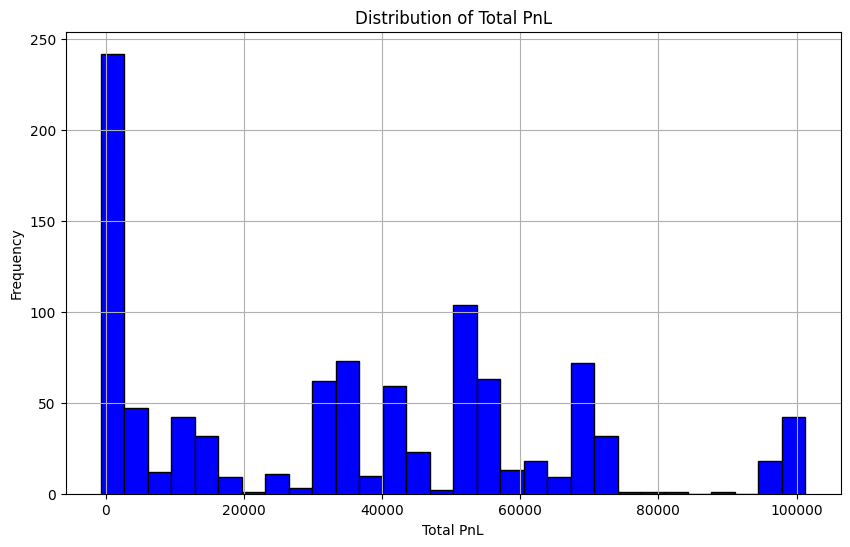

In [136]:
import matplotlib.pyplot as plt

# Assuming trades DataFrame has 'Total PnL' column
total_pnl = trades['Total PnL']

# Plotting histogram
plt.figure(figsize=(10, 6))
plt.hist(total_pnl, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Total PnL')
plt.xlabel('Total PnL')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [232]:
import yfinance as yf
import pandas as pd
import plotly.graph_objs as go
import numpy as np
from plotly.subplots import make_subplots

def fetch_data(ticker, start_date='2020-01-01', end_date='2024-01-01'):
    return yf.download(ticker, start=start_date, end=end_date)

def ewmac(price, vol, Lfast, Lslow):
    fast_ewma = price.ewm(span=Lfast, min_periods=1).mean()
    slow_ewma = price.ewm(span=Lslow, min_periods=1).mean()
    raw_ewmac = fast_ewma - slow_ewma
    return raw_ewmac / vol.ffill()

def calculate_ewmac_signals(data, parameters):
    composite_signal = pd.Series(0, index=data.index)
    for filter_speed in parameters:
        Lfast = filter_speed
        Lslow = 4 * filter_speed
        signal_name = f'EWMAC_{filter_speed}'
        data[signal_name] = scale_cap_forecast(ewmac(data['Close'], data['Volatility'], Lfast, Lslow))
        composite_signal += data[signal_name]
    data['Composite_Signal'] = composite_signal / len(parameters) 
    return data

def scale_cap_forecast(signals, cap=20):
    signals = signals * 10 / signals.abs().mean()
    return signals.clip(-cap, cap)

def calculate_pnl(trades, data, initial_capital, transaction_cost=0.001):
    trades['Position Change'] = trades['Position'].diff().fillna(0)
    trades['Position Cost'] = 0.0
    trades['Realized PnL'] = 0.0
    trades['Unrealized PnL'] = 0.0
    trades['Total PnL'] = 0.0
    trades['Account Size'] = initial_capital

    for i in range(1, len(trades)):
        position_change = trades['Position Change'].iloc[i]
        execution_price = data['Close'].iloc[i]
        previous_position = trades['Position'].iloc[i-1]
        position_cost = trades['Position Cost'].iloc[i-1]

        realized_pnl = 0.0

        if previous_position != 0:
            avg_position_price = position_cost / abs(previous_position)
        else:
            avg_position_price = 0

        if np.sign(position_change) == np.sign(previous_position):
            trades.loc[trades.index[i], 'Position Cost'] = position_cost + (position_change * execution_price)
        else:
            if abs(position_change) > abs(previous_position):
                realized_pnl = (execution_price - avg_position_price) * previous_position + (position_change + previous_position) * execution_price
                trades.loc[trades.index[i], 'Position Cost'] = (position_change + previous_position) * execution_price
            else:
                realized_pnl = (execution_price - avg_position_price) * position_change
                trades.loc[trades.index[i], 'Position Cost'] = position_cost + (position_change * execution_price)

            realized_pnl -= transaction_cost * abs(position_change) * execution_price
            trades.loc[trades.index[i], 'Realized PnL'] = realized_pnl

        trades.loc[trades.index[i], 'Account Size'] -= transaction_cost * abs(position_change) * execution_price

        if trades['Position'].iloc[i] != 0:
            trades.loc[trades.index[i], 'Unrealized PnL'] = trades['Position'].iloc[i] * (execution_price - avg_position_price)
        else:
            trades.loc[trades.index[i], 'Unrealized PnL'] = 0

        trades.loc[trades.index[i], 'Total PnL'] = trades['Realized PnL'].cumsum().iloc[i] + trades['Unrealized PnL'].iloc[i]
        trades.loc[trades.index[i], 'Account Size'] += trades['Unrealized PnL'].iloc[i]

    return trades

def adjust_trade_buffer(data, max_loss_sharpe, window=30):
    rolling_mean = data['Daily_Returns'].rolling(window=window).mean()
    rolling_std = data['Daily_Returns'].rolling(window=window).std()
    rolling_sharpe = rolling_mean / rolling_std
    trade_buffer = (rolling_sharpe.abs() / max_loss_sharpe).clip(lower=1)
    return trade_buffer

def calculate_backtest_metrics(trades, capital, strat):
    daily_pnl = trades['Total PnL'].diff().fillna(0)  # Calculate daily PnL
    cumulative_pnl = trades['Total PnL']
    daily_mean_return = daily_pnl.mean()
    daily_std_dev = daily_pnl.std()
    annualized_return = (daily_mean_return * 252) / capital
    annualized_std_dev = (daily_std_dev * np.sqrt(252)) / capital
    sharpe_ratio = annualized_return / annualized_std_dev 
    annualized_return_pct = annualized_return * 100
    drawdowns = cumulative_pnl - cumulative_pnl.cummax()
    max_drawdown = drawdowns.min()
    avg_drawdown = drawdowns.mean()
    avg_position = trades['Position'].abs().mean()
    total_turnover = trades['Position'].diff().abs().sum()
    annual_turnover = (total_turnover / avg_position / len(trades)) * 252
    skew = daily_pnl.skew()
    lower_tail = daily_pnl.quantile(0.05)
    upper_tail = daily_pnl.quantile(0.95)
    alpha = (cumulative_pnl.iloc[-1] / cumulative_pnl.std()) * np.sqrt(252)
    
    metrics = pd.DataFrame({
        "Initial Capital": capital,
        "Mean Annualised Return  %": annualized_return_pct,
        "Max Drawdown %": (max_drawdown / capital) * 100,
        "Avg Drawdown %": (avg_drawdown / capital) * 100,
        "Annual Standard Deviation %": annualized_std_dev * 100,
        "Sharpe Ratio": sharpe_ratio,
        "Annual Turnover": annual_turnover,
        "Skew": skew,
        "Lower Tail (5th percentile)": lower_tail,
        "Upper Tail (95th percentile)": upper_tail,
        "Cumulative PnL": cumulative_pnl.iloc[-1]
    }, index=[strat]).T
    
    return metrics

def calculate_position_size(capped_signals, risk_target, volatility, price, capital, instrument_weights, fx_rate, idm):
    multiplier = 1000
    weighted_signals = capped_signals.mul(instrument_weights, axis=1)
    average_signal = weighted_signals.sum(axis=1)
    position = round(average_signal * capital * idm * risk_target / (10 * multiplier * price * fx_rate * volatility), 0)
    return position

def plot_combined(trades, price, pnl, composite_signal):
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                        row_heights=[1,1,1,1], vertical_spacing=0.05)

    fig.add_trace(go.Scatter(x=price.index, y=price, mode='lines', name='Price', line=dict(color='blue')), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=pnl.index, y=pnl, mode='lines', name='PNL', line=dict(color='green')), row=2, col=1)
    
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'], mode='lines', name='Position Size', line=dict(color='red')), row=3, col=1)
    
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'] * (trades['Position'] > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip'), row=3, col=1)
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'] * (trades['Position'] < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip'), row=3, col=1)
    
    for i in range(1, len(trades)):
        if trades['Position'].iloc[i] != 0 and trades['Position'].iloc[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=trades.index[i], x1=trades.index[i], y0=0, y1=1, line=dict(color="green" if trades['Position'].iloc[i] > 0 else "red", width=1), opacity=0.1)

    fig.add_trace(go.Scatter(x=composite_signal.index, y=composite_signal, mode='lines', name='Composite Signal', line=dict(color='purple')), row=4, col=1)

    fig.update_layout(title='Combined Position Size, Underlying Price, PNL, and Composite Signal with Direction Change Indicators', xaxis_title='Date')

    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="PNL", row=2, col=1)
    fig.update_yaxes(title_text="Position Size", row=3, col=1)
    fig.update_yaxes(title_text="Composite Signal", row=4, col=1)
    
    fig.show()

def backtest(ticker='BZ=F', start_date='2020-01-01', end_date='2024-06-14', parameters=[4, 8, 16, 32, 64],
             risk_target=0.10, initial_capital=100000, plot=True, transaction_cost=0.01, max_loss_sharpe=0.1):
    strat = "EWMAC_" + '_'.join([str(i) for i in parameters])
    instrument_weights = 1
    fx_rate = 1.0
    idm = 1
    data = fetch_data(ticker, start_date, end_date)
    data['Daily_Returns'] = data['Close'].pct_change()
    data['Volatility'] = data['Daily_Returns'].ewm(span=30, min_periods=0).std()
    data = calculate_ewmac_signals(data, parameters)
    signal_cols = [i for i in data.columns if "EWM" in i]
    data["Ideal Position Size"] = calculate_position_size(data[signal_cols], risk_target, data['Volatility'], data['Close'], initial_capital, instrument_weights, fx_rate, idm)
    data['Trade Buffer'] = adjust_trade_buffer(data, max_loss_sharpe)
    data['Position Size'] = data['Ideal Position Size'].where(
        (data['Ideal Position Size'] - data['Ideal Position Size'].shift(1)).abs() > data['Trade Buffer'],
        other=np.nan
    ).ffill().fillna(0)
    trades = pd.DataFrame(index=data.index)
    trades['Position'] = data["Position Size"]
    trades = calculate_pnl(trades, data, initial_capital, transaction_cost)
    backtest_metrics = calculate_backtest_metrics(trades, initial_capital, strat)
    pd.options.display.float_format = '{:.2f}'.format
    print(backtest_metrics.round(2))
    if plot:
        plot_combined(trades, data['Close'], trades['Total PnL'], data['Composite_Signal'])
    return trades, data

# Running the backtest
trades, data = backtest()


[*********************100%***********************]  1 of 1 completed
                              EWMAC_4_8_16_32_64
Initial Capital                        100000.00
Mean Annualised Return  %                  14.67
Max Drawdown %                            -24.64
Avg Drawdown %                             -8.57
Annual Standard Deviation %                13.83
Sharpe Ratio                                1.06
Annual Turnover                            25.46
Skew                                        1.48
Lower Tail (5th percentile)              -738.87
Upper Tail (95th percentile)             1198.58
Cumulative PnL                          65082.00
